- 본 코드는 발표자료에서 코드확인이 필요한 부분을 담고 있습니다.

# [Unit 4] 데이터 분석

## [Unit 4-1] 데이터 정의
- 다음은 구글 코랩에서 사용하기 위한 드라이브 마운팅 및 사용하는 Python 라이브러리들을 import 하는 과정입니다.

In [ ]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir)

%matplotlib inline
%cd drive/MyDrive/데이콘_서울시민데이터_경진대회

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import os
import os.path as osp
from pathlib import Path

Mounted at /content/drive/
/content/drive/MyDrive/데이콘_서울시민데이터_경진대회


- 다음은 서울시의 지역구에 각 숫자를 할당한 것을 나타내는 코드입니다. (이후 레이블링시 필요함)

In [ ]:
# 실제 25개 지역구 중에서 2개(종로구,동작구) 누락됨 -> 총 23개 지역구
district_list = list([
'강남구',
'강동구',
'강북구',
'강서구',
'관악구',
'광진구',
'구로구',
'금천구',
'노원구',
'도봉구',
'동대문구',
'마포구',
'서대문구',
'서초구',
'성동구',
'성북구',
'송파구',
'양천구',
'영등포구',
'용산구',
'은평구',
'중구',
'중랑구'])

for i, district in enumerate(district_list):
  print(i, district)

district_set = set(district_list)

0 강남구
1 강동구
2 강북구
3 강서구
4 관악구
5 광진구
6 구로구
7 금천구
8 노원구
9 도봉구
10 동대문구
11 마포구
12 서대문구
13 서초구
14 성동구
15 성북구
16 송파구
17 양천구
18 영등포구
19 용산구
20 은평구
21 중구
22 중랑구


### 1. 기상 데이터
- 본 csv 파일은 모든 전처리가 끝난 기상 데이터입니다.
- 자세한 전처리 내역은 [Unit 4-2]에서 확인하실 수 있습니다.
- 전처리가 끝난 기상 데이터는 총 11개의 피쳐를 가지고 있습니다.


- 데이터가 포함하는 전체 년도는 1997~2021년도 입니다.
- 기상 관측 센터를 기준으로 데이터가 존재하기 때문에, 일반적인 서울시 지역구(전체 25개 지역구)와 다른 경우가 있습니다.
- 예를 들어, 동작구, 종로구 정보가 없습니다.
- 또한 잉여 지역에 대한 정보가 존재합니다. (기상청, 남현, 북악산, 북한산, 한강, 현충원)

In [ ]:
df_raw = pd.read_csv("aws_edit/df_train_aws.csv")
df_raw = df_raw.dropna().drop(columns=["Unnamed: 0"]).reset_index(drop=True)
df_raw

,지점명,일시,일강수량_sum_mm,일강수량_mean_mm,일강수량_std_mm,일강수량_max_mm,평균기온_mean_c,평균풍속_mean_ms,최저기온_min_c,최고기온_max_c,최대순간풍속_max_ms,최대순간풍속향_max_deg,집중호우일수
0,강남,2017,995.5,10.820652,26.293209,129.0,25.828261,1.577174,14.6,37.2,19.1,351.6,5.0
1,강남,2018,523.0,5.684783,17.067693,98.0,27.096739,1.518478,17.4,40.0,9.9,340.3,2.0
2,강남,2019,579.0,6.433333,17.185570,115.5,25.817778,1.138889,13.9,37.7,10.4,343.1,1.0
3,강남,2020,1145.5,12.451087,24.334218,101.5,25.422826,1.225275,14.8,36.2,12.3,357.2,4.0
4,강남,2021,428.5,4.657609,14.616702,104.5,26.202174,1.104348,13.6,37.9,11.5,348.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,영등포,2002,851.0,9.250000,27.442197,164.0,24.965934,2.234066,16.0,36.8,16.2,356.9,3.0
648,영등포,2003,1032.0,11.217391,25.730888,160.5,24.378889,1.738462,16.0,33.0,12.6,355.9,3.0
649,영등포,2004,752.5,8.179348,18.940999,100.5,25.865217,1.823913,16.1,38.0,13.3,332.7,2.0
650,영등포,2005,683.0,7.423913,18.566177,124.5,25.852747,1.792308,15.7,38.2,13.9,321.5,2.0


### 2. 지형 데이터
- 지형 데이터는 다음과 같이 3개의 피쳐로 이루어져 있습니다. --> ```면적, 산림면적, 하천 개수```

#### 1) (지역구) 면적 피쳐

In [ ]:
df_raw = pd.read_excel("raw_data/지역구면적.xlsx", usecols=["시군구", "합 계"], skiprows=[1,2])
df_raw = df_raw[:26]
df_raw.rename(columns = {"시군구": "지역구"}, inplace=True)

df_raw

,지역구,합 계
0,소계,605.228541
1,종로구,23.913168
2,중구,9.960304
3,용산구,21.866144
4,성동구,16.861004
5,광진구,17.062939
6,동대문구,14.215623
7,중랑구,18.496082
8,성북구,24.576833
9,강북구,23.600355


#### 2) 지역구 산림면적 피쳐

In [ ]:
df_raw = pd.read_excel("raw_data/산림면적(소유별)(1996_2010,+2015).xlsx", sheet_name="데이터", usecols=["자치구별(2)", "소유별(1)", "2015"])
df_raw = df_raw[df_raw["소유별(1)"]=="합계"].drop(columns=["소유별(1)"]).reset_index(drop=True)
df_raw.rename(columns = {"자치구별(2)": "지역구"}, inplace=True)
df_raw

,지역구,2015
0,소계,15486.0
1,종로구,956.0
2,중구,150.0
3,용산구,180.0
4,성동구,55.0
5,광진구,295.0
6,동대문구,120.0
7,중랑구,532.0
8,성북구,936.0
9,강북구,1290.0


#### 3) 하천 개수 피쳐
- 하천의 하류가 홍수에 영향을 미친다는 지식을 이용하여, 종점명에 지역구가 존재하면 해당 하천을 해당 지역구에 존재한다고 가정했습니다.

In [ ]:
df_raw = pd.read_csv("raw_data/서울시 하천개황 정보.csv", encoding="cp949", usecols=["하천명", "종점명"])

for i, line in enumerate(df_raw["종점명"]):
  for word in line.split():
    if word in district_set:
      df_raw.loc[i,"지역구"] = word

df_raw = df_raw.dropna().drop(columns=["종점명"]).reset_index(drop=True)

df_raw

,하천명,지역구
0,양재천,강남구
1,여의천,서초구
2,고덕천,강동구
3,성내천,송파구
4,대사골천,강동구
5,감이천,송파구
6,도림2지류,관악구
7,탄천,송파구
8,목감천,구로구
9,세곡천,서초구


### 3. 사회/경제 데이터
- 사회/경제 데이터는 다음과 같이 2개의 피쳐로 이루어져 있습니다. --> ```맨홀 개수, 빗물받이 개수```

In [ ]:
df_raw = pd.read_excel("raw_data/social_data.xlsx", skiprows=[1]).reset_index(drop=True)
df_raw

,지역구,맨홀 (개소),빗물받이 (개소)
0,종로구,9843,16183
1,중구,8049,15020
2,용산구,9676,17917
3,성동구,8403,15726
4,광진구,9926,25024
5,동대문구,11989,21593
6,중랑구,12106,18496
7,성북구,14595,22957
8,강북구,10780,16494
9,도봉구,8842,12137


### 4. 타겟 데이터
- 본 데이터는 Target label로 사용할 "지역구별 이재민 피해 현황 (년 단위)"를 나타냅니다.

- 데이터에서 누락된 년도가 지역구별로 제각각으로 존재합니다. (전체 년도는 1971~2020년도)
- 따라서 본 타겟 데이터에서, 존재하는(누락되지 않은) 지역구별 년도를 기준으로 데이터셋을 구성해야 합니다.

In [ ]:
# df_raw는 지역구별로 sheet가 존재하기 때문에, dictionary로 주어진다.
df_raw = pd.read_excel("서울시 이재민 피해현황_220925.xlsx", sheet_name=None)

# 예컨대 "관악구" sheet의 dataframe을 얻고 싶다면 아래와 같이 확인할 수 있다.
district = "관악구"
df = df_raw[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
df.rename(columns = {"이재민\n(명)":"이재민", "인명\n(명)":"인명"}, inplace=True)
df

,년도,총액,이재민,인명
0,2020,0,1,0
1,2019,0,0,0
2,2018,0,0,0
3,2017,0,0,0
4,2016,0,0,0
5,2015,0,0,0
6,2014,0,0,0
7,2013,0,0,0
8,2012,775466,0,0
9,2011,2936273,5324,3


## [Unit 4-2] 분석과정

### 1. 기상 데이터 전처리 과정

In [ ]:
# AWS 전체 데이터
df_1 = pd.read_csv('AWS_날씨데이터/AWS_2017_2021.csv', encoding = 'cp949')
df_2 = pd.read_csv('AWS_날씨데이터/AWS_2007_2016.csv', encoding = 'cp949')
df_3 = pd.read_csv('AWS_날씨데이터/AWS_1997_2006.csv', encoding = 'cp949')
df_set = pd.concat([df_1, df_2,df_3],ignore_index=True).drop_duplicates()

In [ ]:
# AWS 데이터 전처리 
list_columns = df_set.columns[0].split('\t')
df = pd.DataFrame()

col_1 = []
col_2 = []
col_3 = []
col_4 = []
col_5 = []
col_6 = []
col_7 = []
col_8 = []
col_9 = []
col_10 = []
col_11 = []
col_12 = []
col_13 = []


for x in range(0,df_set.count()[0]):
    for y in range(0,13):
        if y == 0:
            col_1.append(df_set[df_set.columns[0]][x].split('\t')[y])
            
        elif y == 1:
            col_2.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 2:
            col_3.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 3:
            col_4.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 4:
            col_5.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 5:
            col_6.append(df_set[df_set.columns[0]][x].split('\t')[y])
            
            
        elif y == 6:
            col_7.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 7:
            col_8.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 8:
            col_9.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 9:
            col_10.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 10:
            col_11.append(df_set[df_set.columns[0]][x].split('\t')[y])
            
            
        elif y == 11:
            col_12.append(df_set[df_set.columns[0]][x].split('\t')[y])
        elif y == 12:
            col_13.append(df_set[df_set.columns[0]][x].split('\t')[y])            
            
            
df["지점"] = col_1
df["지점명"] = col_2
df["일시"] = col_3
df["평균기온(°C)"] = col_4
df["최저기온(°C)"] = col_5
df["최저기온_시각(hhmi)"] = col_6
df["최고기온(°C)"] = col_7
df["최고기온_시각(hhmi)"] = col_8
df["일강수량(mm)"] = col_9
df["최대순간풍속(m/s)"] = col_10
df["최대순간풍속_시각(hhmi)"] = col_11
df["평균풍속(m/s)"] = col_12
df["최대순간풍속풍향(deg)"] = col_13

df.head(1)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온_시각(hhmi),최고기온(°C),최고기온_시각(hhmi),일강수량(mm),최대순간풍속(m/s),최대순간풍속_시각(hhmi),평균풍속(m/s),최대순간풍속풍향(deg)
0,400,강남,2017-01-01,3.5,-.4,626,7,1532,0,3.3,611,1.3,73.1


In [ ]:
df_p = df.copy()

In [ ]:
df_p = df_p[df_p["일시"].str.contains('-06-')
               | df_p["일시"].str.contains('-07-')
               | df_p["일시"].str.contains('-08-')] # 여름철 6~8월 데이터를 활용하기 위해 데이터를 구분

df_p['평균기온(°C)'] = pd.to_numeric(df_p['평균기온(°C)']) # 타입변환
df_p['최저기온(°C)'] = pd.to_numeric(df_p['최저기온(°C)']) # 타입변환
df_p['최고기온(°C)'] = pd.to_numeric(df_p['최고기온(°C)']) # 타입변환
df_p['일강수량(mm)'] = pd.to_numeric(df_p['일강수량(mm)']) # 타입변환
df_p['최대순간풍속(m/s)'] = pd.to_numeric(df_p['최대순간풍속(m/s)']) # 타입변환
df_p['평균풍속(m/s)'] = pd.to_numeric(df_p['평균풍속(m/s)']) # 타입변환
df_p['최대순간풍속풍향(deg)'] = pd.to_numeric(df_p['최대순간풍속풍향(deg)']) # 타입변환


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
df_p['일시'] = df_p['일시'].str[:4]
df_p.head(3)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온_시각(hhmi),최고기온(°C),최고기온_시각(hhmi),일강수량(mm),최대순간풍속(m/s),최대순간풍속_시각(hhmi),평균풍속(m/s),최대순간풍속풍향(deg)
151,400,강남,2017,23.7,17.9,1034,26.8,1302,2.0,9.5,1826,2.3,236.3
152,400,강남,2017,21.1,17.6,552,25.3,1502,0.0,7.3,2051,2.1,284.1
153,400,강남,2017,20.8,17.5,547,25.5,1611,0.0,8.1,1404,2.4,298.1


#### 기상 피쳐 선택
- 일자별 데이터를 활용하지 못하는 관계로, 1개 년도에 여름철 계절성을 포함한 데이터를 넣고자 일강수량,기온, 풍속의 6~8월 기술통계값을 적용

In [ ]:
# 학습 데이터 셋 구축
df_db = df_p[["지점명","일시"]]

In [ ]:
df_db["일강수량_sum_mm"] = df_p.groupby(['일시','지점명'])['일강수량(mm)'].transform('sum')
df_db["일강수량_mean_mm"] = df_p.groupby(['일시','지점명'])['일강수량(mm)'].transform('mean')
df_db["일강수량_std_mm"] = df_p.groupby(['일시','지점명'])['일강수량(mm)'].transform('std')
df_db["일강수량_max_mm"] = df_p.groupby(['일시','지점명'])['일강수량(mm)'].transform('max')

df_db["평균기온_mean_c"] = df_p.groupby(['일시','지점명'])['평균기온(°C)'].transform('mean')
df_db["평균풍속_mean_ms"] = df_p.groupby(['일시','지점명'])['평균풍속(m/s)'].transform('mean')

df_db["최저기온_min_c"] = df_p.groupby(['일시','지점명'])['최저기온(°C)'].transform('min')

df_db["최고기온_max_c"] = df_p.groupby(['일시','지점명'])['최고기온(°C)'].transform('max')
df_db["최대순간풍속_max_ms"] = df_p.groupby(['일시','지점명'])['최대순간풍속(m/s)'].transform('max')
df_db["최대순간풍속향_max_deg"] = df_p.groupby(['일시','지점명'])['최대순간풍속풍향(deg)'].transform('max')

# 일자별 데이터를 활용하지 못하는 관계로, 1개 년도에 여름철 계절성을 포함한 데이터를 넣고자 일강수량,기온, 풍속의 6~8월 기술통계값을 적용

df_db = df_db.drop_duplicates()
df_db = df_db.reset_index(drop='index')
df_db.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,지점명,일시,일강수량_sum_mm,일강수량_mean_mm,일강수량_std_mm,일강수량_max_mm,평균기온_mean_c,평균풍속_mean_ms,최저기온_min_c,최고기온_max_c,최대순간풍속_max_ms,최대순간풍속향_max_deg
0,강남,2017,995.5,10.820652,26.293209,129.0,25.828261,1.577174,14.6,37.2,19.1,351.6
1,강남,2018,523.0,5.684783,17.067693,98.0,27.096739,1.518478,17.4,40.0,9.9,340.3
2,강남,2019,579.0,6.433333,17.185570,115.5,25.817778,1.138889,13.9,37.7,10.4,343.1
3,강남,2020,1145.5,12.451087,24.334218,101.5,25.422826,1.225275,14.8,36.2,12.3,357.2
4,강남,2021,428.5,4.657609,14.616702,104.5,26.202174,1.104348,13.6,37.9,11.5,348.8


#### 집중호우 (일강수량) 횟수 체크

In [ ]:
## 집중호우 (일강수량) 횟수 체크
df_d = df_p[df_p['일강수량(mm)'] > 80] # 일강수량 80이상 (서울시 보편적인 집중호우 기준)
df_d["집중호우일수"] = df_d.groupby(['지점명','일시'])['일강수량(mm)'].transform('count')
df_d = df_d[["지점명", "일시", "집중호우일수"]].drop_duplicates() ## 일강수량 80이상 카운트
df_d = df_d.reset_index(drop='index')
df_d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,지점명,일시,집중호우일수
0,강남,2017,5
1,강남,2018,2
2,강남,2019,1
3,강남,2020,4
4,강남,2021,1
...,...,...,...
556,영등포,2002,3
557,영등포,2003,3
558,영등포,2004,2
559,영등포,2005,2


#### 데이터 합치기 및 추출

In [ ]:
df_train = pd.merge(df_db, df_d, how = 'left', on = ['일시','지점명'] )
df_train["집중호우일수"] = df_train["집중호우일수"].fillna(0)
df_train

,지점명,일시,일강수량_sum_mm,일강수량_mean_mm,일강수량_std_mm,일강수량_max_mm,평균기온_mean_c,평균풍속_mean_ms,최저기온_min_c,최고기온_max_c,최대순간풍속_max_ms,최대순간풍속향_max_deg,집중호우일수
0,강남,2017,995.5,10.820652,26.293209,129.0,25.828261,1.577174,14.6,37.2,19.1,351.6,5.0
1,강남,2018,523.0,5.684783,17.067693,98.0,27.096739,1.518478,17.4,40.0,9.9,340.3,2.0
2,강남,2019,579.0,6.433333,17.185570,115.5,25.817778,1.138889,13.9,37.7,10.4,343.1,1.0
3,강남,2020,1145.5,12.451087,24.334218,101.5,25.422826,1.225275,14.8,36.2,12.3,357.2,4.0
4,강남,2021,428.5,4.657609,14.616702,104.5,26.202174,1.104348,13.6,37.9,11.5,348.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,영등포,2004,752.5,8.179348,18.940999,100.5,25.865217,1.823913,16.1,38.0,13.3,332.7,2.0
653,영등포,2005,683.0,7.423913,18.566177,124.5,25.852747,1.792308,15.7,38.2,13.9,321.5,2.0
654,영등포,2006,1126.0,12.239130,36.731539,225.0,25.667033,1.560440,16.1,37.0,12.6,334.3,4.0
655,현충원,2002,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
#저장하기
df_train.to_csv('aws_edit/df_train_aws.csv')

### 2. 데이터 레이블링 과정
- 본 코드는 앞서 정의된 다양한 데이터들을 모델 학습에 사용하기 위한 데이터셋으로(txt 파일로) 저장하는 과정을 담고 있습니다.

#### 1) 레이블링 기준
- Label 0 : 피해 총량(budget)이 10000 천원 이하인 경우
- Label 1 : 피해 총량(budget)이 10000 천원 초과, 100000 이하인 경우
- Label 2 : 피해 총량(budget)이 100000 천원 초과, 1000000 이하인 경우
- Label 3 : 피해 총량(budget)이 1000000 천원 초과인 경우

In [ ]:
def get_label(budget, missing, passed):
  # budget: 피해 총액 (천원)
  # missing: 이재민 ~ 명당 백만원 (1000 천원)
  # passed: 인명 ~ 명당 삼천만원 (30000 천원)
  budget = budget + 1000*missing + 30000*passed
  if budget < 1e4:
    return 0
  elif budget < 1e5:
    return 1
  elif budget < 1e6:
    return 2
  elif budget > 1e6:
    return 3
  else:
    raise

#### 2) 데이터셋
- 데이터셋 명칭 예시: 
```
데이터셋_이름/{지역구}_{년도}.txt
  e.g., 0_1997.txt
  해당 데이터의 경우 강남구(0번)의 1997년 데이터를 나타낸다.
```
- txt 파일 데이터 구성 예시 :
```
레이블, 기상피쳐_11개, 지형피쳐_3개, 사회/경제피쳐_2개
  e.g., 
  2	507.0	5.51087	19.146196	123.0	25.597826	1.720652	12.6	35.8	29.4	337.0	2.0	39.5010063	714.0	1	14753	24321
```

- 다음은 앞서 정의된 데이터들을 불러오는 코드입니다.

In [ ]:
#1. Label
df_label = pd.read_excel("서울시 이재민 피해현황_220925.xlsx", sheet_name=None)
#2. AWS
df_aws = pd.read_csv("aws_edit/df_train_aws.csv").dropna().drop(columns=["Unnamed: 0"]).reset_index(drop=True)
#3. fixed text via district
df_area = pd.read_excel("raw_data/지역구면적.xlsx", usecols=["시군구", "합 계"], skiprows=[1,2])[1:26].reset_index(drop=True)

df_mount = pd.read_excel("raw_data/산림면적(소유별)(1996_2010,+2015).xlsx", sheet_name="데이터", usecols=["자치구별(2)", "소유별(1)", "2015"])
df_mount = df_mount[df_mount["소유별(1)"]=="합계"].drop(columns=["소유별(1)"]).reset_index(drop=True)

df_river = pd.read_csv("raw_data/서울시 하천개황 정보.csv", encoding="cp949", usecols=["하천명", "종점명"])
for i, line in enumerate(df_river["종점명"]):
  for word in line.split():
    if word in district_set:
      df_river.loc[i,"지역구"] = word
df_river = df_river.dropna().drop(columns=["종점명"]).reset_index(drop=True)


#
df_social = pd.read_excel("raw_data/social_data.xlsx", skiprows=[1]).reset_index(drop=True)


- 다음은 데이터셋(txt파일)을 저장하는 과정입니다.

In [ ]:
label_temp_list = []
os.makedirs("dataset/exp2", exist_ok=True)

# Use this loop to make the whole datasets
for i, district in enumerate(district_list):
  # [0] 피해 현황
  df = df_label[district][["년도", "총액", "이재민\n(명)", "인명\n(명)"]][1:].reset_index(drop=True).astype(int)
  df = df[df["년도"]>=1997]

  #[예외처리] district "중구"
  contain_word = "중구" if district=="중구" else district[:-1]
  # [1] 기상학적 요인
  df2 = df_aws[df_aws["지점명"].str.contains(contain_word)].reset_index(drop=True)

  fixed_txt = ""
  # [2] 지형학적 요인
  fixed_txt += "\t" + str(df_area[df_area["시군구"].str.contains(district)].squeeze()["합 계"]) # 지역구 면적
  fixed_txt += "\t" + str(df_mount[df_mount["자치구별(2)"].str.contains(district)].squeeze()["2015"]) # 지역구 산림 면적
  fixed_txt += "\t" + str(np.sum(df_river["지역구"].str.contains(district))) # 지역구 하천 개수
  # [3] 사회경제적 요인
  df3 = df_social[df_social["지역구"].str.contains(district)].squeeze().to_string(header=False, index=False).split("\n")
  fixed_txt += "\t" + df3[1] # 지역구 맨홀 개수
  fixed_txt += "\t" + df3[2] # 지역구 빗물받이 개수
  
  for index, row in df.iterrows():
    year = row["년도"]

    #[예외처리] df2에서 누락된 년도 제거
    if np.sum(df2["일시"]==year)==0: 
      break

    label_temp_list.append(get_label(row["총액"], row["이재민\n(명)"], row["인명\n(명)"]))
    
    text = ""
    #1. Label
    text += str(get_label(row["총액"], row["이재민\n(명)"], row["인명\n(명)"]))

    #2. AWS
    seq_list = df2[df2["일시"]==year].squeeze().iloc[2:]
    for word in seq_list.to_string(header=False, index=False).split("\n"):
      word = word.strip()
      text += "\t" + word
    
    #3. fixed text via district
    text += fixed_txt

    # Save as TXT file
    with open(f"dataset/exp2/{i}_{year}.txt", "w") as f:
      f.write(text)

- 다음은 각 레이블의 개수를 나타내는 히스토그램입니다. (레이블의 분포 확인 가능)

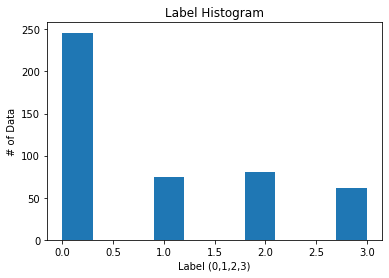

전체 데이터 개수 : 463

레이블 0인 데이터 개수 : 246
레이블 1인 데이터 개수 : 75
레이블 2인 데이터 개수 : 81
레이블 3인 데이터 개수 : 61


In [ ]:
label_temp_list = np.array(label_temp_list)
plt.hist(label_temp_list)
plt.title("Label Histogram")
plt.xlabel("Label (0,1,2,3)")
plt.ylabel("# of Data")
plt.show()

print("전체 데이터 개수 :", len(label_temp_list))
print()
print("레이블 0인 데이터 개수 :", np.sum(label_temp_list==0))
print("레이블 1인 데이터 개수 :",np.sum(label_temp_list==1))
print("레이블 2인 데이터 개수 :", np.sum(label_temp_list==2))
print("레이블 3인 데이터 개수 :", np.sum(label_temp_list==3))

## [Unit 4-3] 모델링
- 다음은 구글 코랩에서 사용하기 위한 드라이브 마운팅 및 사용하는 Python 라이브러리들을 import 하는 과정입니다.

In [ ]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir)

%matplotlib inline
%cd drive/MyDrive/데이콘_서울시민데이터_경진대회

import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

!pip install torchmetrics
from torchmetrics import F1Score

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
import copy

import os
import os.path as osp
from pathlib import Path

Mounted at /content/drive/
/content/drive/MyDrive/데이콘_서울시민데이터_경진대회
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.3 MB/s 


### 데이터셋 개요
1. Input
- 기상학적 요인: 연도/지역구별 AWS 피쳐 11개
- 지형학적 요인: 지역구별 지형 피쳐 3개 --> 면적, 산림 면적, 하천 개수
- 사회경제적 요인: 지역구별 사회경제 피쳐 2개 --> 맨홀, 빗물받이
<br><br>
2. Output
- 피해규모: 연도/지역구별 이재민 피해현황

In [ ]:
path_dataset = "dataset/exp2"
X = []
for filename in os.listdir(path_dataset):
  X.append(osp.join(path_dataset, filename))
print(len(X))

463


- Dataset split ~ Train / Validation --> 7:3



In [ ]:
X_train, X_val = train_test_split(X, test_size=0.3, random_state=2022)

### Basic utilities


1. [클래스] Custom Dataset

In [ ]:
def _to_float_tensor(L: list):
  temp = []
  for word in L:
    temp.append(float(word))
  return torch.tensor(temp)

class CustomDataset(Dataset):
  def __init__(self, file_list, transform=None):
    self.file_list = file_list
    self.transform = transform

  def __getitem__(self, i):
    with open(self.file_list[i], "r") as f:
      line = f.readlines()[0].split("\t")
    
    label = torch.tensor(int(line[0]))        
    aws = _to_float_tensor(line[1:12])
    geo = _to_float_tensor(line[12:15])
    social = _to_float_tensor(line[15:])
    
    sample = {'label': label,
              'aws': aws,
              'geo': geo,
              'social': social,
              'file_name': self.file_list[i]}
    return sample
      
  def __len__(self):
    return len(self.file_list)


batch_size = 32
# Dataset
train_dataset = CustomDataset(file_list=X_train)
val_dataset = CustomDataset(file_list=X_val)
# Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=6,
                                               pin_memory=True,)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=6,
                                             pin_memory=True,)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. [클래스] Basic Network

In [ ]:
class Net(nn.Module):
  def __init__(self, dims_list=[11, 32], out_dim=4):
    super(Net, self).__init__()
    
    fc_list = []
    for i in range(len(dims_list)-1):
      fc_list.append(nn.Linear(dims_list[i], dims_list[i+1]))
    fc_list.append(nn.Linear(dims_list[-1], out_dim))
    
    self.fc_list = nn.ModuleList(fc_list)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = x
    for i in range(len(self.fc_list)-1):
      out = self.fc_list[i](out)
      out = self.relu(out)
    out = self.fc_list[-1](out)

    return out

3. [클래스] Focal Loss for imbalanced data

In [ ]:
class FocalLoss(nn.Module): # for imbalanced data
  def __init__(self, alpha=1, gamma=2, logits=False, reduction='sum'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction
    
    if logits:
      raise ValueError 

  def forward(self, inputs, targets):    
    ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)

    pt = torch.exp(-ce_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

    if self.reduction == 'sum':
      return torch.sum(F_loss)
    else:
      return F_loss

### 1차 모델링 : 기상,지형,사회경제 데이터를 한꺼번에 사용하는 모델

1. [함수] 학습 코드

In [ ]:
def train3(model, Loss, optimizer, num_epochs, save_name=False):
  model = model.to(device)
  f1 = F1Score(num_classes=4)

  loss_dict = {"train_loss":[], "val_loss":[],
               "train_acc":[], "val_acc":[]}
  eval_every = 1
  
  best_test_acc = 0.
  #best_test_loss = np.inf
  early_stop, early_stop_max = 0., 50

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10, verbose=True)
  
  for epoch in range(num_epochs):

    epoch_loss = 0.
    epoch_acc = 0.
    for batch_X in tqdm(train_dataloader):
      aws = batch_X['aws'].to(device)
      geo = batch_X['geo'].to(device)
      social = batch_X['social'].to(device)
      inputs = torch.cat((aws,geo,social), -1)
      labels = batch_X['label'].to(device)

      
      optimizer.zero_grad()
      model.train()

      # Forward Pass      
      outputs = model(inputs)
      train_loss = Loss(outputs, labels)
      epoch_loss += train_loss.item()
      epoch_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

    epoch_loss /= len(train_dataloader.dataset)
    epoch_acc /= len(train_dataloader.dataset)
    loss_dict["train_loss"].append(epoch_loss)
    loss_dict["train_acc"].append(epoch_acc)

    if epoch % eval_every == 0:
      model.eval()

      test_loss = 0.
      test_acc = 0.
      for batch_X in tqdm(val_dataloader):
        aws = batch_X['aws'].to(device)
        geo = batch_X['geo'].to(device)
        social = batch_X['social'].to(device)
        inputs = torch.cat((aws,geo,social), -1)
        labels = batch_X['label'].to(device)

        # Forward Pass
        outputs = model(inputs)
        batch_loss = Loss(outputs, labels)
        test_loss += batch_loss.item()
        test_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      test_loss /= len(val_dataloader.dataset)
      test_acc /= len(val_dataloader.dataset)
      loss_dict["val_loss"].append(test_loss)
      loss_dict["val_acc"].append(test_acc)
      
      
      # scheduler
      scheduler.step(test_loss)

      
      if best_test_acc < test_acc:
        best_test_acc = test_acc
        early_stop = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f} *')
        best_model = copy.deepcopy(model)
        if save_name:
          torch.save(model.state_dict(), save_name)
      else:
        early_stop += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f}')
      print(f'\t\t Train acc: {epoch_acc:.8f}, Test acc: {test_acc:.8f}')
      

    if early_stop >= early_stop_max:
      break
    
  return loss_dict, best_model

2. [클래스] 모델 정의 및 학습 진행

100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch [1/200], Train Loss: 3470.85149619, Test Loss: 2918.03189636 *
		 Train acc: 0.12345679, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch [2/200], Train Loss: 2885.68888949, Test Loss: 2517.28044908
		 Train acc: 0.12654321, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


Epoch [3/200], Train Loss: 2464.44276560, Test Loss: 2117.60732352
		 Train acc: 0.15123457, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Epoch [4/200], Train Loss: 2037.69275957, Test Loss: 1734.01031362
		 Train acc: 0.13888890, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [5/200], Train Loss: 1633.83985844, Test Loss: 1343.51999494
		 Train acc: 0.15123457, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Epoch [6/200], Train Loss: 1227.65511369, Test Loss: 1057.33801006
		 Train acc: 0.17283951, Test acc: 0.12230216


100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch [7/200], Train Loss: 939.66686710, Test Loss: 745.60327675
		 Train acc: 0.17901234, Test acc: 0.11510792


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch [8/200], Train Loss: 638.34451897, Test Loss: 459.35647342
		 Train acc: 0.17283951, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


Epoch [9/200], Train Loss: 357.28221677, Test Loss: 175.30479903
		 Train acc: 0.16666667, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Epoch [10/200], Train Loss: 107.32450085, Test Loss: 94.59986581 *
		 Train acc: 0.28086421, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Epoch [11/200], Train Loss: 97.74053823, Test Loss: 81.08176252
		 Train acc: 0.50308645, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch [12/200], Train Loss: 64.29654887, Test Loss: 60.88059855
		 Train acc: 0.42592594, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 11.09it/s]


Epoch [13/200], Train Loss: 55.08427580, Test Loss: 50.06481934
		 Train acc: 0.37037036, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Epoch [14/200], Train Loss: 51.30352972, Test Loss: 47.80378383
		 Train acc: 0.45679012, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Epoch [15/200], Train Loss: 43.77025731, Test Loss: 44.93356301
		 Train acc: 0.43518519, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 13.57it/s]


Epoch [16/200], Train Loss: 40.11862854, Test Loss: 38.95233286
		 Train acc: 0.40432099, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


Epoch [17/200], Train Loss: 37.46153834, Test Loss: 37.74340820
		 Train acc: 0.43209878, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 13.55it/s]


Epoch [18/200], Train Loss: 34.61651144, Test Loss: 31.25156232
		 Train acc: 0.42592594, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Epoch [19/200], Train Loss: 30.49305832, Test Loss: 28.45687998
		 Train acc: 0.42283949, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [20/200], Train Loss: 27.21706250, Test Loss: 25.65117684
		 Train acc: 0.45061728, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch [21/200], Train Loss: 24.91670265, Test Loss: 24.87226132
		 Train acc: 0.41666666, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


Epoch [22/200], Train Loss: 22.41941980, Test Loss: 22.59249527
		 Train acc: 0.46604937, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


Epoch [23/200], Train Loss: 21.41718007, Test Loss: 20.17884925
		 Train acc: 0.44135803, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch [24/200], Train Loss: 19.02173907, Test Loss: 20.30559886
		 Train acc: 0.42901236, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch [25/200], Train Loss: 17.84558749, Test Loss: 17.91922502
		 Train acc: 0.44753087, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


Epoch [26/200], Train Loss: 16.99463409, Test Loss: 17.65619841
		 Train acc: 0.45987654, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.70it/s]


Epoch [27/200], Train Loss: 16.25059928, Test Loss: 18.62568785
		 Train acc: 0.44753087, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


Epoch [28/200], Train Loss: 17.44825747, Test Loss: 16.79453371
		 Train acc: 0.45679012, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 11.48it/s]


Epoch [29/200], Train Loss: 16.53732648, Test Loss: 16.34144142
		 Train acc: 0.43827161, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch [30/200], Train Loss: 16.83141763, Test Loss: 14.99648170 *
		 Train acc: 0.45370370, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


Epoch [31/200], Train Loss: 16.83991564, Test Loss: 18.34528686
		 Train acc: 0.45679012, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch [32/200], Train Loss: 14.94867537, Test Loss: 14.54076863
		 Train acc: 0.44444445, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.50it/s]


Epoch [33/200], Train Loss: 12.78704364, Test Loss: 14.68743589
		 Train acc: 0.45370370, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


Epoch [34/200], Train Loss: 13.38133122, Test Loss: 14.55205157
		 Train acc: 0.46296296, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Epoch [35/200], Train Loss: 13.09098324, Test Loss: 12.90016361
		 Train acc: 0.46296296, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch [36/200], Train Loss: 11.78635601, Test Loss: 13.12497168
		 Train acc: 0.43518519, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


Epoch [37/200], Train Loss: 13.28507054, Test Loss: 16.26337219
		 Train acc: 0.47222221, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


Epoch [38/200], Train Loss: 12.49817231, Test Loss: 13.66479349
		 Train acc: 0.43518519, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


Epoch [39/200], Train Loss: 11.19952234, Test Loss: 12.38635331
		 Train acc: 0.46604937, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch [40/200], Train Loss: 11.25163264, Test Loss: 16.38816252
		 Train acc: 0.47839507, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Epoch [41/200], Train Loss: 12.57944929, Test Loss: 11.46820431
		 Train acc: 0.46913579, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch [42/200], Train Loss: 10.92401316, Test Loss: 12.62709155
		 Train acc: 0.47530866, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 11.22it/s]


Epoch [43/200], Train Loss: 11.23105279, Test Loss: 11.86892393
		 Train acc: 0.44444445, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Epoch [44/200], Train Loss: 9.86529500, Test Loss: 11.39910296
		 Train acc: 0.44444445, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [45/200], Train Loss: 10.58544298, Test Loss: 14.76080092
		 Train acc: 0.44753087, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


Epoch [46/200], Train Loss: 12.57506675, Test Loss: 12.31998899
		 Train acc: 0.43827161, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch [47/200], Train Loss: 12.62303819, Test Loss: 11.60151837
		 Train acc: 0.47530866, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


Epoch [48/200], Train Loss: 9.54732693, Test Loss: 10.31443776
		 Train acc: 0.47222221, Test acc: 0.39568347


100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Epoch [49/200], Train Loss: 9.23256062, Test Loss: 9.09260252
		 Train acc: 0.44753087, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch [50/200], Train Loss: 9.12354729, Test Loss: 9.97137166
		 Train acc: 0.45679012, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch [51/200], Train Loss: 11.41849082, Test Loss: 13.32974803
		 Train acc: 0.51543212, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Epoch [52/200], Train Loss: 9.59825705, Test Loss: 15.81029571
		 Train acc: 0.46913579, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Epoch [53/200], Train Loss: 10.58787185, Test Loss: 12.20547946
		 Train acc: 0.45370370, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Epoch [54/200], Train Loss: 9.31125862, Test Loss: 10.60713646
		 Train acc: 0.47839507, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Epoch [55/200], Train Loss: 8.05877502, Test Loss: 9.93317089
		 Train acc: 0.45987654, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch [56/200], Train Loss: 9.19047138, Test Loss: 10.98643735
		 Train acc: 0.49382716, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch [57/200], Train Loss: 8.76122882, Test Loss: 10.86730024
		 Train acc: 0.45061728, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


Epoch [58/200], Train Loss: 8.51708090, Test Loss: 9.31118588
		 Train acc: 0.45987654, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Epoch [59/200], Train Loss: 8.91085878, Test Loss: 14.66542086 *
		 Train acc: 0.45370370, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch [60/200], Train Loss: 11.03738883, Test Loss: 8.18672175
		 Train acc: 0.47839507, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Epoch [61/200], Train Loss: 8.38574530, Test Loss: 8.11523553
		 Train acc: 0.50308645, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 11.17it/s]


Epoch [62/200], Train Loss: 8.14318911, Test Loss: 8.48502921
		 Train acc: 0.46913579, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Epoch [63/200], Train Loss: 7.29228478, Test Loss: 8.82315667
		 Train acc: 0.50000000, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


Epoch [64/200], Train Loss: 6.76640650, Test Loss: 8.34695533
		 Train acc: 0.48148149, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch [65/200], Train Loss: 6.80134099, Test Loss: 8.55915843
		 Train acc: 0.48765433, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch [66/200], Train Loss: 7.88470592, Test Loss: 7.60583485
		 Train acc: 0.45679012, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [67/200], Train Loss: 7.89027499, Test Loss: 10.46589189 *
		 Train acc: 0.46913579, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch [68/200], Train Loss: 9.03116165, Test Loss: 8.38529727
		 Train acc: 0.49691358, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


Epoch [69/200], Train Loss: 6.82882537, Test Loss: 8.96762612
		 Train acc: 0.47222221, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch [70/200], Train Loss: 7.18474406, Test Loss: 12.49438411
		 Train acc: 0.46604937, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Epoch [71/200], Train Loss: 8.56781202, Test Loss: 9.38528234
		 Train acc: 0.45061728, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Epoch [72/200], Train Loss: 6.94378574, Test Loss: 5.71827110
		 Train acc: 0.49074075, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Epoch [73/200], Train Loss: 6.40376056, Test Loss: 10.16328046
		 Train acc: 0.50308645, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Epoch [74/200], Train Loss: 9.06869816, Test Loss: 10.94387214
		 Train acc: 0.45679012, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch [75/200], Train Loss: 8.03831882, Test Loss: 8.41321844
		 Train acc: 0.47222221, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


Epoch [76/200], Train Loss: 7.92810710, Test Loss: 10.48748307
		 Train acc: 0.43827161, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch [77/200], Train Loss: 8.37043066, Test Loss: 7.73348878
		 Train acc: 0.45987654, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch [78/200], Train Loss: 8.20163029, Test Loss: 8.69508878
		 Train acc: 0.47839507, Test acc: 0.34532374


100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch [79/200], Train Loss: 7.37952921, Test Loss: 5.95561119
		 Train acc: 0.47530866, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch [80/200], Train Loss: 6.93049009, Test Loss: 6.67410152
		 Train acc: 0.48765433, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 11.24it/s]


Epoch [81/200], Train Loss: 6.80540429, Test Loss: 6.50451968
		 Train acc: 0.50000000, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch [82/200], Train Loss: 6.60095194, Test Loss: 9.67115817
		 Train acc: 0.48148149, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


Epoch 00083: reducing learning rate of group 0 to 9.0000e-05.
Epoch [83/200], Train Loss: 9.19187364, Test Loss: 7.59540794
		 Train acc: 0.45370370, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Epoch [84/200], Train Loss: 6.52769488, Test Loss: 5.66335618
		 Train acc: 0.46604937, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch [85/200], Train Loss: 5.19605298, Test Loss: 5.00839914
		 Train acc: 0.51543212, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


Epoch [86/200], Train Loss: 5.29337456, Test Loss: 5.95758529
		 Train acc: 0.47839507, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


Epoch [87/200], Train Loss: 5.16973459, Test Loss: 5.77346785
		 Train acc: 0.50925928, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch [88/200], Train Loss: 5.36088390, Test Loss: 5.62396246
		 Train acc: 0.48148149, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Epoch [89/200], Train Loss: 5.24932546, Test Loss: 5.62969263
		 Train acc: 0.50000000, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch [90/200], Train Loss: 5.70866520, Test Loss: 6.46615030
		 Train acc: 0.48765433, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch [91/200], Train Loss: 5.83895469, Test Loss: 6.06375336
		 Train acc: 0.47530866, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


Epoch [92/200], Train Loss: 5.07499393, Test Loss: 5.86032291
		 Train acc: 0.51851851, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


Epoch [93/200], Train Loss: 5.44307111, Test Loss: 5.19524617
		 Train acc: 0.50308645, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch [94/200], Train Loss: 5.55069996, Test Loss: 6.61756919
		 Train acc: 0.47222221, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch [95/200], Train Loss: 5.63001393, Test Loss: 4.93629505
		 Train acc: 0.47530866, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch [96/200], Train Loss: 5.05964184, Test Loss: 5.14858460
		 Train acc: 0.51851851, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch [97/200], Train Loss: 4.82310632, Test Loss: 5.25804144
		 Train acc: 0.51851851, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch [98/200], Train Loss: 5.09873254, Test Loss: 5.32130531
		 Train acc: 0.49074075, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch [99/200], Train Loss: 5.27089025, Test Loss: 6.24590658
		 Train acc: 0.49074075, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch [100/200], Train Loss: 5.71964596, Test Loss: 6.83614064
		 Train acc: 0.47530866, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch [101/200], Train Loss: 6.30071539, Test Loss: 5.04916135
		 Train acc: 0.48765433, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch [102/200], Train Loss: 5.81355033, Test Loss: 5.24093123
		 Train acc: 0.48456791, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch [103/200], Train Loss: 4.67085665, Test Loss: 4.71855877
		 Train acc: 0.49691358, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch [104/200], Train Loss: 5.39782515, Test Loss: 5.32773645
		 Train acc: 0.52469134, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch [105/200], Train Loss: 4.85308434, Test Loss: 5.32838369
		 Train acc: 0.50308645, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


Epoch [106/200], Train Loss: 4.71948558, Test Loss: 5.65262999
		 Train acc: 0.50308645, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch [107/200], Train Loss: 4.80955780, Test Loss: 5.82209185
		 Train acc: 0.50000000, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Epoch [108/200], Train Loss: 4.90418464, Test Loss: 4.74467784
		 Train acc: 0.47530866, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.44it/s]


Epoch [109/200], Train Loss: 4.54888560, Test Loss: 5.28910976
		 Train acc: 0.51234567, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


Epoch [110/200], Train Loss: 4.49978472, Test Loss: 5.60931440
		 Train acc: 0.49691358, Test acc: 0.41726619


100%|██████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch [111/200], Train Loss: 4.47248912, Test Loss: 5.50701048
		 Train acc: 0.51234567, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch [112/200], Train Loss: 4.76047986, Test Loss: 4.93941698
		 Train acc: 0.50308645, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch [113/200], Train Loss: 5.02385362, Test Loss: 4.81378596
		 Train acc: 0.50308645, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


Epoch 00114: reducing learning rate of group 0 to 2.7000e-05.
Epoch [114/200], Train Loss: 5.30849881, Test Loss: 4.89505469
		 Train acc: 0.51851851, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch [115/200], Train Loss: 4.41746018, Test Loss: 4.71706352
		 Train acc: 0.52469134, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch [116/200], Train Loss: 4.37700922, Test Loss: 4.59452677
		 Train acc: 0.48148149, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch [117/200], Train Loss: 4.21975020, Test Loss: 4.70462530
		 Train acc: 0.51234567, Test acc: 0.46043167


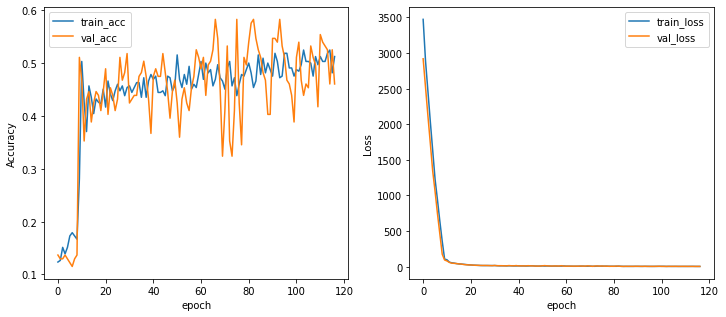

In [ ]:
model3 = Net([11+3+2, 64], 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
num_epochs = 200
learning_rate = 3e-4

#criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss()
adam_optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

#loss_dict, best_model = train3(model3, criterion, adam_optimizer, num_epochs, save_name="model/exp2/model3.pt")
loss_dict, best_model = train3(model3, criterion, adam_optimizer, num_epochs, save_name=False)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_dict["train_acc"], label="train_acc")
plt.plot(loss_dict["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_dict["train_loss"], label="train_loss")
plt.plot(loss_dict["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

3. Validation 재현

In [ ]:
model3 = Net([11+3+2, 64], 4)
model3.load_state_dict(torch.load("model/exp2/model3.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  model3 = model3.to(device)
  model3.eval()

  test_loss = 0.
  test_acc = 0.
  preds = []
  labels_list = []
  for batch_X in tqdm(val_dataloader):
    aws = batch_X['aws'].to(device)
    geo = batch_X['geo'].to(device)
    social = batch_X['social'].to(device)
    inputs = torch.cat((aws,geo,social), -1)
    labels = batch_X['label'].to(device)
    
    # Forward Pass
    outputs = model3(inputs)
    preds.append(torch.argmax(outputs, -1))
    labels_list.append(labels)

print()
print()
print("-"*30)

preds = torch.cat(preds)
labels_list = torch.cat(labels_list)
accuracy = float(torch.sum(preds == labels_list) / len(preds)) * 100

print(f"\t1. Accuracy : {accuracy:.2f}%")
print()


idx = labels_list == 3
recall_3 = float(torch.sum(preds[idx]>1)/len(preds[idx])) * 100
print(f"\t2. Recall of Label 3 : {recall_3:.2f}%")
print()

preds[preds != 0] = 1
labels_list[labels_list != 0] = 1
acc_01 = float(torch.sum(preds==labels_list)/len(preds)) * 100
print(f"\t3. 0/1 Accuracy : {acc_01:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 5/5 [00:00<00:00, 17.12it/s]



------------------------------
	1. Accuracy : 46.04%

	2. Recall of Label 3 : 52.38%

	3. 0/1 Accuracy : 66.91%


### 2차 모델링 : 기상,지형,사회경제 데이터를 순차적으로 사용하는 모델

1. [함수] 학습 코드

In [ ]:
def train2(model, Loss, optimizer, num_epochs, save_name=False):
  model = model.to(device)
  f1 = F1Score(num_classes=4)

  loss_dict = {"train_loss":[], "val_loss":[],
               "train_acc":[], "val_acc":[]}
  eval_every = 1
  
  best_test_acc = 0.
  #best_test_loss = np.inf
  early_stop, early_stop_max = 0., 50

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10, verbose=True)
  
  for epoch in range(num_epochs):

    epoch_loss = 0.
    epoch_acc = 0.
    for batch_X in tqdm(train_dataloader):
      aws = batch_X['aws'].to(device)
      geo = batch_X['geo'].to(device)
      social = batch_X['social'].to(device)
      labels = batch_X['label'].to(device)

      
      optimizer.zero_grad()
      model.train()

      # Forward Pass      
      outputs = model(aws, geo, social)
      train_loss = Loss(outputs, labels)
      epoch_loss += train_loss.item()
      epoch_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

    epoch_loss /= len(train_dataloader.dataset)
    epoch_acc /= len(train_dataloader.dataset)
    loss_dict["train_loss"].append(epoch_loss)
    loss_dict["train_acc"].append(epoch_acc)

    if epoch % eval_every == 0:
      model.eval()

      test_loss = 0.
      test_acc = 0.
      for batch_X in tqdm(val_dataloader):
        aws = batch_X['aws'].to(device)
        geo = batch_X['geo'].to(device)
        social = batch_X['social'].to(device)
        labels = batch_X['label'].to(device)

        # Forward Pass
        outputs = model(aws, geo, social)
        batch_loss = Loss(outputs, labels)
        test_loss += batch_loss.item()
        test_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      test_loss /= len(val_dataloader.dataset)
      test_acc /= len(val_dataloader.dataset)
      loss_dict["val_loss"].append(test_loss)
      loss_dict["val_acc"].append(test_acc)
      
      
      # scheduler
      scheduler.step(test_loss)

      
      if best_test_acc < test_acc:
        best_test_acc = test_acc
        early_stop = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f} *')
        best_model = copy.deepcopy(model)
        if save_name:
          torch.save(model.state_dict(), save_name)
      else:
        early_stop += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f}')
      print(f'\t\t Train acc: {epoch_acc:.8f}, Test acc: {test_acc:.8f}')
      

    if early_stop >= early_stop_max:
      break
    
  return loss_dict, best_model

2. [클래스] 모델 정의

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # 11, 3, 2
    self.Net1 = Net([11, 32], 8)
    self.Net2 = Net([3+8, 32], 8)
    self.Net3 = Net([2+8, 16], 4)

  def forward(self, aws, geo, social):
    out = self.Net1(aws)
    out = self.Net2(torch.cat((out, geo), -1))
    out = self.Net3(torch.cat((out, social), -1))   
    return out


3. 학습 진행

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch [1/200], Train Loss: 1216.18110412, Test Loss: 916.06107380 *
		 Train acc: 0.12345679, Test acc: 0.15107913


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


Epoch [2/200], Train Loss: 905.69444444, Test Loss: 637.22406138 *
		 Train acc: 0.12345679, Test acc: 0.15827338


100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch [3/200], Train Loss: 660.31030010, Test Loss: 472.43633023 *
		 Train acc: 0.16358025, Test acc: 0.20863310


100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Epoch [4/200], Train Loss: 471.22668947, Test Loss: 298.31031679
		 Train acc: 0.13888890, Test acc: 0.20143884


100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Epoch [5/200], Train Loss: 279.36416475, Test Loss: 139.87462676 *
		 Train acc: 0.13271604, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Epoch [6/200], Train Loss: 157.63931406, Test Loss: 114.72176575 *
		 Train acc: 0.40123457, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch [7/200], Train Loss: 121.92177798, Test Loss: 78.88627350
		 Train acc: 0.45061728, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


Epoch [8/200], Train Loss: 70.21956041, Test Loss: 50.66122063
		 Train acc: 0.41358024, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch [9/200], Train Loss: 50.02173671, Test Loss: 51.62937389
		 Train acc: 0.27777779, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Epoch [10/200], Train Loss: 46.05363276, Test Loss: 46.04003599
		 Train acc: 0.37345678, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Epoch [11/200], Train Loss: 43.46010896, Test Loss: 45.46307812
		 Train acc: 0.36728394, Test acc: 0.30215827


100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Epoch [12/200], Train Loss: 41.01457167, Test Loss: 42.27684581
		 Train acc: 0.34259260, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 14.08it/s]


Epoch [13/200], Train Loss: 38.98191179, Test Loss: 40.61203179
		 Train acc: 0.36111110, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch [14/200], Train Loss: 36.93107680, Test Loss: 37.49622702
		 Train acc: 0.34876543, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Epoch [15/200], Train Loss: 34.38368644, Test Loss: 36.10682448
		 Train acc: 0.37037036, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Epoch [16/200], Train Loss: 32.22977551, Test Loss: 35.47156398
		 Train acc: 0.36728394, Test acc: 0.33093524


100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Epoch [17/200], Train Loss: 30.42450865, Test Loss: 32.15449074
		 Train acc: 0.35185185, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 15.54it/s]


Epoch [18/200], Train Loss: 27.96662747, Test Loss: 31.25716329
		 Train acc: 0.36728394, Test acc: 0.26618704


100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Epoch [19/200], Train Loss: 25.76488509, Test Loss: 28.74400604
		 Train acc: 0.37037036, Test acc: 0.28776979


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Epoch [20/200], Train Loss: 24.05792057, Test Loss: 26.06463711
		 Train acc: 0.35185185, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


Epoch [21/200], Train Loss: 21.81563313, Test Loss: 25.72283826
		 Train acc: 0.39814815, Test acc: 0.30215827


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch [22/200], Train Loss: 20.33911704, Test Loss: 23.82137249
		 Train acc: 0.37962964, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.93it/s]


Epoch [23/200], Train Loss: 19.65386869, Test Loss: 22.54714527
		 Train acc: 0.37037036, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Epoch [24/200], Train Loss: 17.61378196, Test Loss: 22.31241789
		 Train acc: 0.41049382, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Epoch [25/200], Train Loss: 16.82157388, Test Loss: 23.77407727
		 Train acc: 0.41666666, Test acc: 0.15107913


100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


Epoch [26/200], Train Loss: 20.67613824, Test Loss: 19.45818148
		 Train acc: 0.38888890, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 14.48it/s]


Epoch [27/200], Train Loss: 15.79655840, Test Loss: 19.76114243
		 Train acc: 0.34876543, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Epoch [28/200], Train Loss: 14.14735427, Test Loss: 16.42234627
		 Train acc: 0.44135803, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch [29/200], Train Loss: 13.77046411, Test Loss: 15.68399586
		 Train acc: 0.40740740, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Epoch [30/200], Train Loss: 13.21380686, Test Loss: 14.56167482
		 Train acc: 0.40432099, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Epoch [31/200], Train Loss: 14.09280403, Test Loss: 14.45223406
		 Train acc: 0.38888890, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Epoch [32/200], Train Loss: 11.04556206, Test Loss: 11.76322421
		 Train acc: 0.41358024, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.86it/s]


Epoch [33/200], Train Loss: 10.12358427, Test Loss: 11.18091973
		 Train acc: 0.41975307, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


Epoch [34/200], Train Loss: 9.05675540, Test Loss: 10.29628990
		 Train acc: 0.36419752, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


Epoch [35/200], Train Loss: 7.88296229, Test Loss: 9.27838294
		 Train acc: 0.41358024, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 15.71it/s]


Epoch [36/200], Train Loss: 7.47055107, Test Loss: 8.45573815
		 Train acc: 0.41049382, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 15.91it/s]


Epoch [37/200], Train Loss: 6.41186884, Test Loss: 7.83610853
		 Train acc: 0.41049382, Test acc: 0.26618704


100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Epoch [38/200], Train Loss: 6.28461224, Test Loss: 7.01607634
		 Train acc: 0.40740740, Test acc: 0.28776979


100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch [39/200], Train Loss: 5.18541729, Test Loss: 8.68822101
		 Train acc: 0.35185185, Test acc: 0.17266187


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Epoch [40/200], Train Loss: 5.95822098, Test Loss: 4.88702862
		 Train acc: 0.36111110, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 14.18it/s]


Epoch [41/200], Train Loss: 4.25196919, Test Loss: 3.16492575 *
		 Train acc: 0.36419752, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


Epoch [42/200], Train Loss: 3.66328708, Test Loss: 3.61818267 *
		 Train acc: 0.37654322, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


Epoch [43/200], Train Loss: 5.28039824, Test Loss: 7.55088351
		 Train acc: 0.37037036, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


Epoch [44/200], Train Loss: 5.91261952, Test Loss: 3.92566492
		 Train acc: 0.38580248, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Epoch [45/200], Train Loss: 3.49733389, Test Loss: 2.87019941
		 Train acc: 0.40123457, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Epoch [46/200], Train Loss: 2.68621651, Test Loss: 2.42078682
		 Train acc: 0.36419752, Test acc: 0.23021583


100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Epoch [47/200], Train Loss: 2.51504652, Test Loss: 2.82352239
		 Train acc: 0.41358024, Test acc: 0.25899279


100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Epoch [48/200], Train Loss: 3.80921428, Test Loss: 6.13822838
		 Train acc: 0.34876543, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


Epoch [49/200], Train Loss: 5.01126216, Test Loss: 6.00642818
		 Train acc: 0.38580248, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch [50/200], Train Loss: 3.88147714, Test Loss: 3.03668040 *
		 Train acc: 0.41049382, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch [51/200], Train Loss: 2.46977980, Test Loss: 1.87283915 *
		 Train acc: 0.45061728, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Epoch [52/200], Train Loss: 2.58978226, Test Loss: 0.92756520
		 Train acc: 0.42901236, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Epoch [53/200], Train Loss: 3.21400195, Test Loss: 4.64500570
		 Train acc: 0.36111110, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


Epoch [54/200], Train Loss: 3.23086401, Test Loss: 1.99193878
		 Train acc: 0.39814815, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


Epoch [55/200], Train Loss: 1.86552852, Test Loss: 3.90554170
		 Train acc: 0.42901236, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [56/200], Train Loss: 3.77981402, Test Loss: 6.70655680
		 Train acc: 0.33950618, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Epoch [57/200], Train Loss: 6.04011884, Test Loss: 12.15682023
		 Train acc: 0.44135803, Test acc: 0.19424461


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


Epoch [58/200], Train Loss: 9.74715911, Test Loss: 11.24534365
		 Train acc: 0.32098764, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Epoch [59/200], Train Loss: 8.66351681, Test Loss: 11.26912640
		 Train acc: 0.34876543, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


Epoch [60/200], Train Loss: 7.55406759, Test Loss: 7.27934441
		 Train acc: 0.39506173, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch [61/200], Train Loss: 5.37282788, Test Loss: 4.91120290
		 Train acc: 0.34876543, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 14.47it/s]


Epoch [62/200], Train Loss: 3.38907412, Test Loss: 1.03386629
		 Train acc: 0.44135803, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 00063: reducing learning rate of group 0 to 9.0000e-05.
Epoch [63/200], Train Loss: 1.35694841, Test Loss: 1.77013167
		 Train acc: 0.47222221, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Epoch [64/200], Train Loss: 1.22096551, Test Loss: 1.08545457
		 Train acc: 0.46913579, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Epoch [65/200], Train Loss: 1.02472971, Test Loss: 1.01099320
		 Train acc: 0.48456791, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 14.86it/s]


Epoch [66/200], Train Loss: 1.21265752, Test Loss: 0.95755866
		 Train acc: 0.45679012, Test acc: 0.39568347


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Epoch [67/200], Train Loss: 0.98103559, Test Loss: 0.64341501
		 Train acc: 0.46604937, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


Epoch [68/200], Train Loss: 0.69386255, Test Loss: 0.62379499
		 Train acc: 0.50617284, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


Epoch [69/200], Train Loss: 0.73738819, Test Loss: 0.79743100
		 Train acc: 0.50308645, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [70/200], Train Loss: 0.75913896, Test Loss: 0.94122081 *
		 Train acc: 0.50925928, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Epoch [71/200], Train Loss: 0.86701671, Test Loss: 0.78046964
		 Train acc: 0.47839507, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch [72/200], Train Loss: 0.70381441, Test Loss: 0.71984720
		 Train acc: 0.48148149, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 14.75it/s]


Epoch [73/200], Train Loss: 0.64853322, Test Loss: 0.59209094
		 Train acc: 0.51851851, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Epoch [74/200], Train Loss: 0.71688682, Test Loss: 1.03456667
		 Train acc: 0.48765433, Test acc: 0.28057554


100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Epoch [75/200], Train Loss: 0.94005587, Test Loss: 0.99870627 *
		 Train acc: 0.43518519, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Epoch [76/200], Train Loss: 1.15719574, Test Loss: 0.81358348
		 Train acc: 0.46296296, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Epoch [77/200], Train Loss: 0.83146034, Test Loss: 0.72454366
		 Train acc: 0.49382716, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


Epoch [78/200], Train Loss: 0.66732008, Test Loss: 0.74469391
		 Train acc: 0.51234567, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.40it/s]


Epoch [79/200], Train Loss: 0.73826824, Test Loss: 0.61778270 *
		 Train acc: 0.50925928, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 14.96it/s]


Epoch [80/200], Train Loss: 0.79483488, Test Loss: 0.66666653
		 Train acc: 0.52160496, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch [81/200], Train Loss: 0.74708698, Test Loss: 0.79896659
		 Train acc: 0.47839507, Test acc: 0.61151081


100%|██████████| 5/5 [00:00<00:00, 14.63it/s]


Epoch [82/200], Train Loss: 0.75723356, Test Loss: 0.83561999
		 Train acc: 0.51543212, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


Epoch [83/200], Train Loss: 0.82152684, Test Loss: 0.80075775
		 Train acc: 0.46604937, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.28it/s]


Epoch 00084: reducing learning rate of group 0 to 2.7000e-05.
Epoch [84/200], Train Loss: 0.72384390, Test Loss: 0.85793498
		 Train acc: 0.54629630, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch [85/200], Train Loss: 0.72544051, Test Loss: 0.61834359
		 Train acc: 0.49382716, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


Epoch [86/200], Train Loss: 0.64601543, Test Loss: 0.66316381
		 Train acc: 0.54938269, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


Epoch [87/200], Train Loss: 0.61521402, Test Loss: 0.57638778
		 Train acc: 0.51851851, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 14.52it/s]


Epoch [88/200], Train Loss: 0.64701898, Test Loss: 0.66255936
		 Train acc: 0.48765433, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.69it/s]


Epoch [89/200], Train Loss: 0.67452644, Test Loss: 0.65712603
		 Train acc: 0.46913579, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Epoch [90/200], Train Loss: 0.63694210, Test Loss: 0.63019744
		 Train acc: 0.52160496, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch [91/200], Train Loss: 0.61496113, Test Loss: 0.62706937
		 Train acc: 0.53086418, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch [92/200], Train Loss: 0.62252391, Test Loss: 0.62779720
		 Train acc: 0.53703701, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


Epoch [93/200], Train Loss: 0.60853092, Test Loss: 0.62844349
		 Train acc: 0.52777779, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


Epoch [94/200], Train Loss: 0.60021822, Test Loss: 0.63756795
		 Train acc: 0.52469134, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Epoch [95/200], Train Loss: 0.60363625, Test Loss: 0.61016039
		 Train acc: 0.53395063, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Epoch [96/200], Train Loss: 0.59729995, Test Loss: 0.60906868
		 Train acc: 0.50925928, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Epoch [97/200], Train Loss: 0.62245233, Test Loss: 0.62566733
		 Train acc: 0.52160496, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Epoch 00098: reducing learning rate of group 0 to 8.1000e-06.
Epoch [98/200], Train Loss: 0.61454605, Test Loss: 0.59085231
		 Train acc: 0.52469134, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


Epoch [99/200], Train Loss: 0.59037497, Test Loss: 0.59943882
		 Train acc: 0.54629630, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Epoch [100/200], Train Loss: 0.58188604, Test Loss: 0.60265517
		 Train acc: 0.54320985, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


Epoch [101/200], Train Loss: 0.58698716, Test Loss: 0.59582596
		 Train acc: 0.52160496, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


Epoch [102/200], Train Loss: 0.58569047, Test Loss: 0.59320906
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Epoch [103/200], Train Loss: 0.58258957, Test Loss: 0.60904743
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Epoch [104/200], Train Loss: 0.57966514, Test Loss: 0.59567916
		 Train acc: 0.55555558, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Epoch [105/200], Train Loss: 0.58114453, Test Loss: 0.58837478
		 Train acc: 0.52160496, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.56it/s]


Epoch [106/200], Train Loss: 0.58885334, Test Loss: 0.59866063
		 Train acc: 0.54012346, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch [107/200], Train Loss: 0.58587056, Test Loss: 0.59519955
		 Train acc: 0.52777779, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch [108/200], Train Loss: 0.61008087, Test Loss: 0.60589981
		 Train acc: 0.50925928, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch 00109: reducing learning rate of group 0 to 2.4300e-06.
Epoch [109/200], Train Loss: 0.59677653, Test Loss: 0.59633094
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch [110/200], Train Loss: 0.57946295, Test Loss: 0.59207989
		 Train acc: 0.54629630, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Epoch [111/200], Train Loss: 0.57637928, Test Loss: 0.59751479
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 14.01it/s]


Epoch [112/200], Train Loss: 0.57552081, Test Loss: 0.59291927
		 Train acc: 0.53086418, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Epoch [113/200], Train Loss: 0.57312320, Test Loss: 0.59020218
		 Train acc: 0.54320985, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch [114/200], Train Loss: 0.57523949, Test Loss: 0.59200497
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Epoch [115/200], Train Loss: 0.57386303, Test Loss: 0.59944078
		 Train acc: 0.54938269, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Epoch [116/200], Train Loss: 0.57419399, Test Loss: 0.59677321
		 Train acc: 0.54012346, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


Epoch [117/200], Train Loss: 0.57735798, Test Loss: 0.59277133
		 Train acc: 0.54012346, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Epoch [118/200], Train Loss: 0.57381352, Test Loss: 0.59729217
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Epoch [119/200], Train Loss: 0.57508438, Test Loss: 0.59815579
		 Train acc: 0.54320985, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


Epoch 00120: reducing learning rate of group 0 to 7.2900e-07.
Epoch [120/200], Train Loss: 0.57418288, Test Loss: 0.59143381
		 Train acc: 0.54938269, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


Epoch [121/200], Train Loss: 0.57347423, Test Loss: 0.59007134
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Epoch [122/200], Train Loss: 0.57297889, Test Loss: 0.59264561
		 Train acc: 0.52777779, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [123/200], Train Loss: 0.57377968, Test Loss: 0.59484758
		 Train acc: 0.54629630, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


Epoch [124/200], Train Loss: 0.57278916, Test Loss: 0.59421854
		 Train acc: 0.54320985, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [125/200], Train Loss: 0.57284925, Test Loss: 0.59423675
		 Train acc: 0.54938269, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Epoch [126/200], Train Loss: 0.57269977, Test Loss: 0.59434940
		 Train acc: 0.53703701, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.31it/s]


Epoch [127/200], Train Loss: 0.57284741, Test Loss: 0.59534911
		 Train acc: 0.54012346, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 13.37it/s]


Epoch [128/200], Train Loss: 0.57296642, Test Loss: 0.59470939
		 Train acc: 0.54012346, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Epoch [129/200], Train Loss: 0.57346225, Test Loss: 0.59493366
		 Train acc: 0.54012346, Test acc: 0.59712231


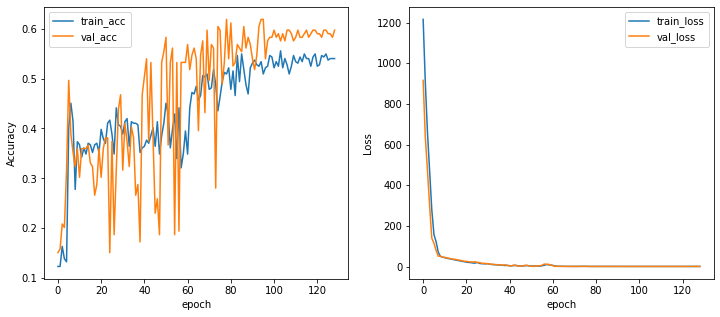

In [ ]:
model2 = Model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
num_epochs = 200
learning_rate = 3e-4

#criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss()
adam_optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

#loss_dict, best_model = train2(model2, criterion, adam_optimizer, num_epochs, save_name="model/exp2/model2.pt")
loss_dict, best_model = train2(model2, criterion, adam_optimizer, num_epochs, save_name=False)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_dict["train_acc"], label="train_acc")
plt.plot(loss_dict["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_dict["train_loss"], label="train_loss")
plt.plot(loss_dict["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

4. Validation 재현

In [ ]:
model2 = Model()
model2.load_state_dict(torch.load("model/exp2/model2.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  model2 = model2.to(device)
  model2.eval()

  test_loss = 0.
  test_acc = 0.
  preds = []
  labels_list = []
  for batch_X in tqdm(val_dataloader):
    aws = batch_X['aws'].to(device)
    geo = batch_X['geo'].to(device)
    social = batch_X['social'].to(device)
    labels = batch_X['label'].to(device)

    # Forward Pass
    outputs = model2(aws, geo, social)
    preds.append(torch.argmax(outputs, -1))
    labels_list.append(labels)

print()
print()
print("-"*30)

preds = torch.cat(preds)
labels_list = torch.cat(labels_list)
accuracy = float(torch.sum(preds == labels_list) / len(preds)) * 100

print(f"\t1. Accuracy : {accuracy:.2f}%")
print()


idx = labels_list == 3
recall_3 = float(torch.sum(preds[idx]>1)/len(preds[idx])) * 100
print(f"\t2. Recall of Label 3 : {recall_3:.2f}%")
print()

preds[preds != 0] = 1
labels_list[labels_list != 0] = 1
acc_01 = float(torch.sum(preds==labels_list)/len(preds)) * 100
print(f"\t3. 0/1 Accuracy : {acc_01:.2f}%")

100%|██████████| 5/5 [00:00<00:00, 11.49it/s]



------------------------------
	1. Accuracy : 61.87%

	2. Recall of Label 3 : 66.67%

	3. 0/1 Accuracy : 68.35%


### (부록) 시뮬레이션 - 2022년 관악구 기상 데이터를 모델에 넣어본 결과
- 올해 여름 관악구의 집중호우 피해정도를 ```Label 3``` 으로 예측하는 것을 확인할 수 있습니다.

In [ ]:
# 전처리된 기상 데이터 (2022년 관악구 AWS) 를 불러와서 사용한다.
aws = []
for word in seq_list.to_string(header=False, index=False).split("\n"):
  word = word.strip()
  aws.append(word)
print("aws features :", aws)

# 지형, 사회경제 데이터는 연도와 상관없이 동일하기에, 2020년 관악구 데이터를 불러와서 사용한다.
with open("dataset/exp2/4_2020.txt", "r") as f:
  txt_data = f.readline().split("\t")
  geo = txt_data[-5:-2]
  social = txt_data[-2:]
print("geo features :", geo)
print("social features :", social)

aws features : ['1491.5', '16.211957', '45.069131', '305.5', '23.632609', '1.747826', '13.0', '34.5', '10.7', '354.4', '5']
geo features : ['29.5693556', '1744.0', '2']
social features : ['11369', '24909']


In [ ]:
model2 = Model()
model2.load_state_dict(torch.load("model/exp2/model2.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _to_float_tensor(L: list):
  temp = []
  for word in L:
    temp.append(float(word))
  return torch.tensor(temp)


with torch.no_grad():
  model2 = model2.to(device)
  model2.eval()

  aws = _to_float_tensor(aws).to(device)
  geo = _to_float_tensor(geo).to(device)
  social = _to_float_tensor(social).to(device)

  # Forward Pass
  outputs = model2(aws, geo, social)
  print("예측한 Label 값 :", int(torch.argmax(outputs, -1)))



예측한 Label 값 : 3


# [Unit 6] 액션플랜

## [Unit 6-2] 대피소 배치

### 서울시 이재민임시주거시설 시각화 (지도 만들기)

1. 데이터 로드

In [ ]:
import pandas as pd
file = '서울시 이재민임시주거시설.csv'
raw_f = pd.read_csv(file, encoding = 'cp949')

- 데이터 상위 5개 확인

In [ ]:
raw_f.head()

,시설번호,지역코드,시설일련번호,시도명,시군구명,시설구분코드,시설구분,수용시설명,도로명주소코드,법정동코드,행정동코드,상세주소,시설면적,이재민수용능력,관리부서,지자체담당자연락처,경도,위도,X좌표,Y좌표
0,1598,1126000000,454,서울특별시,중랑구,7,기타시설,신내종합사회복지관,1126010200104810000016707,1.126010e+09,1126058000,서울특별시 중랑구 봉화산로 153(상봉동 신내12단지신내아파트),679,261,이상철,010-2981-5785,127.091200,37.605376,208053.079781,556203.460142
1,1599,1126000000,484,서울특별시,중랑구,7,기타시설,라코지스테이서울(민간숙박시설),1126010200101280040016365,1.126010e+09,1126059000,서울특별시 중랑구 망우로 232(상봉동),2500,136,NaN,NaN,127.078427,37.594337,206926.210660,554977.245453
2,1600,1126000000,12,서울특별시,중랑구,1,학교,중화고등학교,1126010300100210004013489,1.126010e+09,1126060000,서울특별시 중랑구 봉화산로27길 62(중화동),900,272,서미화,010-4312-4636,127.083054,37.604647,207333.854455,556121.882776
3,1601,1126000000,461,서울특별시,중랑구,1,학교,장안중학교,1126010300102880026013997,1.126010e+09,1126060000,서울특별시 중랑구 동일로 780(중화동),2190,675,원동선,010-9342-2305,127.080726,37.600530,207128.615921,555664.811674
4,1602,1126000000,477,서울특별시,중랑구,4,관공서,상봉2동 복합청사,1126010200101260000014555,1.126010e+09,1126059000,서울특별시 중랑구 동일로114길 10(상봉동),164,50,NaN,NaN,127.080977,37.593121,207151.533266,554842.495241


- 데이터 컬럼 및 속성정보 확인

In [ ]:
raw_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시설번호       1150 non-null   int64  
 1   지역코드       1150 non-null   int64  
 2   시설일련번호     1150 non-null   int64  
 3   시도명        1150 non-null   object 
 4   시군구명       1150 non-null   object 
 5   시설구분코드     1150 non-null   int64  
 6   시설구분       1150 non-null   object 
 7   수용시설명      1150 non-null   object 
 8   도로명주소코드    1149 non-null   object 
 9   법정동코드      1149 non-null   float64
 10  행정동코드      1150 non-null   int64  
 11  상세주소       1150 non-null   object 
 12  시설면적       1150 non-null   int64  
 13  이재민수용능력    1150 non-null   int64  
 14  관리부서       856 non-null    object 
 15  지자체담당자연락처  662 non-null    object 
 16  경도         1150 non-null   float64
 17  위도         1150 non-null   float64
 18  X좌표        1150 non-null   float64
 19  Y좌표        1150 non-null   float64
dtypes: float

- 결측치 개수 확인

In [ ]:
raw_f.isnull().sum()

시설번호           0
지역코드           0
시설일련번호         0
시도명            0
시군구명           0
시설구분코드         0
시설구분           0
수용시설명          0
도로명주소코드        1
법정동코드          1
행정동코드          0
상세주소           0
시설면적           0
이재민수용능력        0
관리부서         294
지자체담당자연락처    488
경도             0
위도             0
X좌표            0
Y좌표            0
dtype: int64

2. 관악구 근처에 해당하는 지역구 (금천구, 관악구, 동작구, 구로구, 서초구, 강남구)에 해당하는 데이터 정보만 가져오기

In [ ]:
raw_f_near_gwanak = raw_f[raw_f['시군구명'].isin(['금천구', '관악구', '동작구', '구로구', '서초구', '강남구'])]
raw_f_near_gwanak = raw_f_near_gwanak.reset_index()
raw_f_near_gwanak

,index,시설번호,지역코드,시설일련번호,시도명,시군구명,시설구분코드,시설구분,수용시설명,도로명주소코드,...,행정동코드,상세주소,시설면적,이재민수용능력,관리부서,지자체담당자연락처,경도,위도,X좌표,Y좌표
0,137,3800,1159000000,11,서울특별시,동작구,1,학교,서울신상도초등학교,1159010200102040333026309,...,1159054000,서울특별시 동작구 장승배기로 14(상도동),530,203,오장길,NaN,126.944064,37.500276,195053.813444,544536.217802
1,138,3801,1159000000,13,서울특별시,동작구,1,학교,서울상도초등학교,1159010200102380002020971,...,1159056000,서울특별시 동작구 성대로21길 62(상도동),680,261,권병진,02-822-0078,126.937230,37.499710,194449.542300,544473.794599
2,139,3802,1159000000,49,서울특별시,동작구,1,학교,국사봉중학교,1159010200102140437021332,...,1159056000,서울특별시 동작구 양녕로20길 20(상도동),907,348,최화섭,NaN,126.945022,37.493712,195138.159311,543807.625919
3,140,3803,1159000000,87,서울특별시,동작구,1,학교,숭실대학교,1159010200105110000033836,...,1159053000,서울특별시 동작구 상도로 369(상도동),851,327,황준성,NaN,126.958280,37.497243,196310.790126,544198.955294
4,141,3804,1159000000,10,서울특별시,동작구,1,학교,서울강남초등학교,1159010200100070168033947,...,1159053000,서울특별시 동작구 강남초등길 15(상도1동),198,76,김진경,010-3442-0256,126.953676,37.505995,195904.110661,545170.514606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,972,10212,1154500000,332,서울특별시,금천구,4,관공서,가산종합사회복지관,1154510100101440003015759,...,1154551000,서울특별시 금천구 가산로 129(가산동),170,65,최선용,02-868-6856,126.891763,37.476873,190426.147139,541942.884324
264,973,10213,1154500000,10,서울특별시,금천구,1,학교,정심초등학교,1154510200101820044007783,...,1154564000,서울특별시 금천구 독산로78다길 89(독산동),500,192,김성곤,NaN,126.908460,37.471646,191902.508761,541361.178572
265,974,10214,1154500000,6,서울특별시,금천구,1,학교,가산초등학교,1154510200101430023012048,...,1154561000,서울특별시 금천구 남부순환로 1304-11 (독산동),500,192,안성미,028644089,126.896406,37.477953,190836.998698,542062.263542
266,975,10215,1154500000,7,서울특별시,금천구,1,학교,안천중학교,1154510200110890000013439,...,1154561000,서울특별시 금천구 한내로 69-44 (독산동),900,346,오창영,NaN,126.887722,37.459219,190066.335712,539983.849697


- 3. 시각화에 사용할 컬럼들만 가져오기

In [ ]:
df = raw_f_near_gwanak[['시설번호', '지역코드', '시설일련번호', '시도명', '시군구명', '시설구분코드', '시설구분',
       '수용시설명', '도로명주소코드', '법정동코드', '행정동코드', '상세주소', '시설면적', '이재민수용능력',
                  '경도', '위도', 'X좌표', 'Y좌표']]

df

,시설번호,지역코드,시설일련번호,시도명,시군구명,시설구분코드,시설구분,수용시설명,도로명주소코드,법정동코드,행정동코드,상세주소,시설면적,이재민수용능력,경도,위도,X좌표,Y좌표
0,3800,1159000000,11,서울특별시,동작구,1,학교,서울신상도초등학교,1159010200102040333026309,1.159010e+09,1159054000,서울특별시 동작구 장승배기로 14(상도동),530,203,126.944064,37.500276,195053.813444,544536.217802
1,3801,1159000000,13,서울특별시,동작구,1,학교,서울상도초등학교,1159010200102380002020971,1.159010e+09,1159056000,서울특별시 동작구 성대로21길 62(상도동),680,261,126.937230,37.499710,194449.542300,544473.794599
2,3802,1159000000,49,서울특별시,동작구,1,학교,국사봉중학교,1159010200102140437021332,1.159010e+09,1159056000,서울특별시 동작구 양녕로20길 20(상도동),907,348,126.945022,37.493712,195138.159311,543807.625919
3,3803,1159000000,87,서울특별시,동작구,1,학교,숭실대학교,1159010200105110000033836,1.159010e+09,1159053000,서울특별시 동작구 상도로 369(상도동),851,327,126.958280,37.497243,196310.790126,544198.955294
4,3804,1159000000,10,서울특별시,동작구,1,학교,서울강남초등학교,1159010200100070168033947,1.159010e+09,1159053000,서울특별시 동작구 강남초등길 15(상도1동),198,76,126.953676,37.505995,195904.110661,545170.514606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,10212,1154500000,332,서울특별시,금천구,4,관공서,가산종합사회복지관,1154510100101440003015759,1.154510e+09,1154551000,서울특별시 금천구 가산로 129(가산동),170,65,126.891763,37.476873,190426.147139,541942.884324
264,10213,1154500000,10,서울특별시,금천구,1,학교,정심초등학교,1154510200101820044007783,1.154510e+09,1154564000,서울특별시 금천구 독산로78다길 89(독산동),500,192,126.908460,37.471646,191902.508761,541361.178572
265,10214,1154500000,6,서울특별시,금천구,1,학교,가산초등학교,1154510200101430023012048,1.154510e+09,1154561000,서울특별시 금천구 남부순환로 1304-11 (독산동),500,192,126.896406,37.477953,190836.998698,542062.263542
266,10215,1154500000,7,서울특별시,금천구,1,학교,안천중학교,1154510200110890000013439,1.154510e+09,1154561000,서울특별시 금천구 한내로 69-44 (독산동),900,346,126.887722,37.459219,190066.335712,539983.849697


### 1) 시군구명이 관악구인 지역의 이재민수용시설 명치과 최대수용인원 시각화

In [ ]:
df[df['시군구명'] == '관악구'].head(1)

,시설번호,지역코드,시설일련번호,시도명,시군구명,시설구분코드,시설구분,수용시설명,도로명주소코드,법정동코드,행정동코드,상세주소,시설면적,이재민수용능력,경도,위도,X좌표,Y좌표
15,3866,1162000000,386,서울특별시,관악구,1,학교,구암고등학교,1162010100117120025000001,1.162010e+09,1162056500,서울특별시 관악구 성현로 57(봉천동),852,327,126.950288,37.49236,195603.709218,543657.370393


### 시각화한 지도에 미니맵 추가하기

In [ ]:
from folium.plugins import MiniMap
import folium
from folium.plugins import MarkerCluster

# 지도 생성하기
m = folium.Map(location=[37.49236, 126.950288],
               zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)  # 클러스터 추가하기


# 미니맵 추가 
minimap = MiniMap()
m.add_child(minimap) 


# 대피소 마커 추가하기
for i in range(len(df)):
    lat = df.loc[i, '위도']
    long = df.loc[i, '경도']
    name = df.loc[i, '수용시설명']
    num = df.loc[i, '이재민수용능력']


    folium.Marker([lat, long],tooltip= name, popup='%d명'%num).add_to(marker_cluster)    
m